In [1]:
import carla

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from time import sleep
from copy import deepcopy

In [3]:
client = carla.Client("localhost", 2000)
client.set_timeout(10)

In [4]:
def load_map(reload_map: bool, map_name: str):
    if reload_map:
        world = client.load_world(map_name)
    else:
        world = client.get_world()

        # Spawn point
        origin = carla.Location(0.0, 0.0, 0.0)

        world.debug.draw_string(
            origin,
            "o",
            draw_shadow=False,
            color=carla.Color(r=255, g=0, b=0),
            life_time=20.0,
            persistent_lines=False,
        )
    return world

In [5]:
world =load_map(reload_map=True, map_name="Town01")

In [6]:
spectator = world.get_spectator()

In [7]:
camera_bp = world.get_blueprint_library().find('sensor.camera.semantic_segmentation')
camera_transform = carla.Transform(carla.Location(x=0.0, y=0.0, z=32.0), carla.Rotation(yaw=+00, pitch=-90))
camera_bp.set_attribute("image_size_x",str(512))
camera_bp.set_attribute("image_size_y",str(512))
camera_bp.set_attribute("fov",str(90))
camera = world.spawn_actor(camera_bp, camera_transform)

In [8]:
def get_image(data):
    global img, frame

    frame = data
    raw = np.array(data.raw_data).astype('uint8')
    bgra = np.reshape(raw, (512, 512, 4))
    bgra = Image.fromarray(bgra, 'RGBA')
    img = bgra.convert("L")
    
camera.listen(lambda data: get_image(data))

In [13]:
map = "Town01"
save_dir = f"maps/{map}/"

stride = 50.0
x_min, x_max = 0, 550
y_min, y_max = 0, 550
z = 32.0

X = np.arange(x_min, x_max+stride, stride)
Y = np.arange(y_min, y_max+stride, stride)

In [14]:
def convert_and_save(img, img_path):
    frame.convert(carla.ColorConverter.CityScapesPalette)
    frame.save_to_disk(img_path)

for x in X:
    for y in Y:
        loc = carla.Location(x=x, y=y, z=z)
        camera.set_location(loc)
        spectator.set_transform(camera.get_transform())
        img_path = f"{save_dir}/{map}-{int(x)},{int(y)}.jpg"
        convert_and_save(img, img_path)
        sleep(0.1)

In [30]:
img.save(img_path)
im = Image.open(img_path)

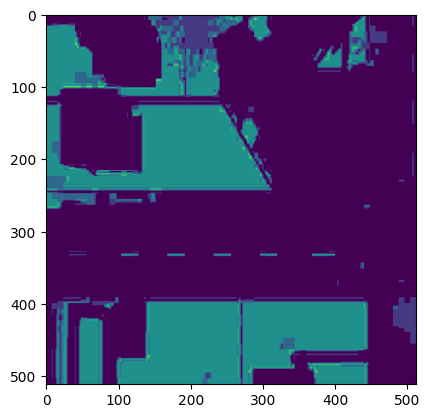

In [31]:
plt.imshow(im)
plt.show()

In [45]:
print(np.array(img).shape)

(512, 512, 3)


In [ ]:
import cv2
from pathlib import Path

from mosaic import VideMosaic

is_first_frame = True

for x in X:
    for y in Y:

        loc = carla.Location(x=x, y=y, z=z)
        camera.set_location(loc)
        img_path = f"{save_dir}/{map}-{int(x)},{int(y)}.jpg"
        img.save(img_path)

        if is_first_frame:
            video_mosaic = VideMosaic(np.array(img, dtype=np.uint8), detector_type="sift")
            is_first_frame = False
            continue
        

        # process each frame
        video_mosaic.process_frame(np.array(img, dtype=np.uint8))
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.imwrite('mosaic.jpg', video_mosaic.output_img)

